# Objective: To develop a mathematical understanding of PCA

# Test data

In [2]:
import numpy as np
from scipy import linalg as LA


X = np.array([
        [0.387,4878, 5.42],
        [0.723,12104,5.25],
        [1,12756,5.52],
        [1.524,6787,3.94],
    ])
X -= np.mean(X, axis=0)

# Non-Iinear Iterative Partial Least-Squares (NIPALS) algorithm

Steps to compute PCA using NIPALS algorithm

* Step 1: Initialize an arbitrary column vector $\mathbf{t}_{a}$ either randomly or by just copying any column of X. 
* Step 2: Take very column of $\mathbf{X}$, $\mathbf{X_k}$ and regress it onto the $\mathbf{t}_{a}$ vector and store the regression coefficeints as $\mathbf{p}_{ka}$. (Note: This simply means performing an ordinary least squares regression ($y=mx$) with $x=t_{a}$ and $y=X_{k}$ with $m=(\mathbf{x^T}\mathbf{x})^{-1}\mathbf{x^T}\mathbf{y}$). In the current notation we get 
$$p_{ka}=\frac{\mathbf{t_a^T}\mathbf{X}_{k}}{\mathbf{t_a^T}\mathbf{t_a}}$$

Repeat it for each of the columns of $X$ to get the entire vector $\mathbf{p}_{k}$. This is shown in the illustration
above where each column from $X$ is regressed, one at a time, on $\mathbf{t}_{a}$, to calculate the loading entry, $\mathbf{𝑝}_{ka}$ 

In practice we don’t do this one column at time; we can regress all columns in $X$ in go: $$\mathbf{p_a^T}=\frac{1}{\mathbf{t_a^T}\mathbf{t_a}}.\mathbf{t_a^T}\mathbf{X_a}$$  where $\mathbf{t_a}$ is an $N \times 1$ column vector, and $\mathbf{X}_{a}$ us an $N \times K$ matrix.
* The loading vector $\mathbf{p_a^T}$ won’t have unit length (magnitude) yet. So we simply rescale it to have
magnitude of 1.0: $$\mathbf{p_a^T}=\frac{\mathbf{p_a^T}}{\sqrt{\mathbf{p_a^T}\mathbf{p_a}}}$$
* Step 4: Regress every row in $X$ onto this normalized loadings vector. As illustrated below, in our linear regression the rows in X are our y-variable each time, while the loadings vector is our x-variable. The regression coefficient becomes the score value for that $𝑖^{th}$ row:

$$p_{i,a}=\frac{\mathbf{x}_{i}^{T}\mathbf{p}_{a}}{\mathbf{p}_{a}^{T}\mathbf{p}_{a}}$$
where $x_{i}^{T}$ is a $K \times 1$ column vector. We can combine these $N$ separate least-squares models and
calculate them in one go to get the entire vector, 

$$\mathbf{t}_{a}^{T}=\frac{1}{\mathbf{p}_{a}^{T}\mathbf{p}_{a}}\mathbf{X}\mathbf{p}_{a}^{T}$$  where $p_{a}$ is a $K \times 1$ column vector.
* Step 5: Continue looping over steps 2,3,4 until the change in vector $t_{a}$ is below a chosen tolerance
* Step 6: On convergence, the score vector and the loading vectors, $\mathbf{t}_{a}$ and $\mathbf{p}_{a}$ are stored as the $a^{th}$ column in matrix $\mathbf{T}$ and $\mathbf{P}$. We then deflate the $\mathbf{X}$ matrix. This crucial step removes the variability captured in this component ($t_{a}$ and $p_{a}$) from $\mathbf{X}$:

$$E_{a}=X_{a}-t_{a}p_{a}^{T}$$

$$X_{a+1} = E_{a}$$ 

For the first component, $X_{a}$ is just the preprocessed raw data. So we can see that the second component is actually calculated on the residuals $E_{1}$, obtained after extracting the first component. This is called deflation, and nicely shows why each component is orthogonal to the others. Each subsequent component is only seeing variation remaining after removing all the others; there is no possibility that two components can explain the same type of variability. After deflation we go back to step 1 and repeat the entire process for the next component. 

## IMPLEMENTATION IN PYTHON

In [3]:
def PCA(X,no_components):
    tol = 0.0000001
    it=1000
    obsCount,varCount = X.shape
    Xa = X - np.mean(X, axis = 0) 
    #Xh = X-np.tile(np.mean(X,axis=0).reshape(-1,1).T, obsCount).reshape(4,3)
    T = np.zeros((obsCount,no_components))
    P = np.zeros((varCount,no_components))
    pcvar = np.zeros((varCount,1))
    varTotal = np.sum(np.var(Xa,axis=0,ddof=1))
    currVar = varTotal
    nr=0
    for h in range(no_components):
        th = Xa[:,0].reshape(-1,1)
        ende = False
        while ende != True:
            nr = nr + 1
            ph = np.dot(Xa.T,th)/np.dot(th.T,th)
            ph = ph /np.linalg.norm(ph)
            thnew = np.dot(Xa,ph)/np.dot(ph.T,ph)
            prec = np.dot((thnew-th).T,(thnew-th))
            th = thnew
            if prec <= (tol*tol):
                ende = True
            elif it <=nr:
                ende = True
                print("Iternation stops without convergence")
        Ea = Xa - np.dot(th,ph.T)
        Xa = Ea    
        T[:,h] = th.flatten()
        P[:,h] = ph.flatten()
        oldVar = currVar
        currVar = np.sum(np.var(Xa,axis=0,ddof=1))
        pcvar[h] = (oldVar - currVar) / varTotal
        nr = 0
    return T,P,pcvar      

## Advantages of the NIPALS algorithm
* The NIPALS algorithm computes one component at a time. The first component computed is
equivalent to the t1 and p1 vectors that would have been found from an eigenvalue or singular value
decomposition.
* The algorithm can handle missing data in X.
* The algorithm always converges, but the convergence can sometimes be slow.
* It is also known as the Power algorithm to calculate eigenvectors and eigenvalues.
* It works well for very large data sets.
* It is used by most software packages, especially those that handle missing data.
* Of interest: it is well known that Google used this algorithm for the early versions of their search engine, called PageRank148.

In [4]:
no_components=3
T, P, pcvar = PCA(X, no_components)

print("T (Scores)")
print(T)
print(" ")
print("P (Loadings)")
print(P)
print(np.sqrt(pcvar)/np.sum(np.sqrt(pcvar)))

T (Scores)
[[-4.25324997e+03 -8.41288672e-01  8.37859036e-03]
 [ 2.97275001e+03 -1.25977272e-01 -1.82476780e-01]
 [ 3.62475003e+03 -1.56843494e-01  1.65224286e-01]
 [-2.34425007e+03  1.12410944e+00  8.87390330e-03]]
 
P (Loadings)
[[ 1.21901390e-05  5.66460728e-01  8.24088735e-01]
 [ 9.99999997e-01  5.32639787e-05 -5.14047689e-05]
 [ 7.30130279e-05 -8.24088733e-01  5.66460726e-01]]
[[9.99753412e-01]
 [2.10083377e-04]
 [3.65048880e-05]]


# SVD

In [5]:
from numpy.linalg import svd 
U, S, PTrans = svd(X, full_matrices=False)
Sigma = np.diag(S)
T=np.dot(U,Sigma)
P=PTrans.T

print("T (Scores)")
print(T)
print(" ")
print("P (Loadings)")
print(P)
print("Sigma (Variance)")
print(S)

T (Scores)
[[-4.25324997e+03 -8.41288672e-01 -8.37858943e-03]
 [ 2.97275001e+03 -1.25977271e-01  1.82476780e-01]
 [ 3.62475003e+03 -1.56843494e-01 -1.65224286e-01]
 [-2.34425007e+03  1.12410944e+00 -8.87390454e-03]]
 
P (Loadings)
[[ 1.21901390e-05  5.66460727e-01 -8.24088736e-01]
 [ 9.99999997e-01  5.32639789e-05  5.14047691e-05]
 [ 7.30130279e-05 -8.24088734e-01 -5.66460725e-01]]
Sigma (Variance)
[6.74994067e+03 1.41840009e+00 2.46466604e-01]


# SKLEARN PCA

In [6]:
from sklearn.decomposition import PCA
pca = PCA()  
T=pca.fit_transform(X)
Prans=pca.components_ #eigen vectors.T
latent = pca.explained_variance_
explained = pca.explained_variance_ratio_
P=PTrans.T
S=pca.singular_values_
Sigma=np.diag(S)

print("T (Scores)")
print(T)
print(" ")
print("P (Loadings)")
print(P)
print("Sigma (Variance)")
print(S)
#print(pca.singular_values_/np.sqrt(3))

T (Scores)
[[ 4.25324997e+03 -8.41288672e-01 -8.37858943e-03]
 [-2.97275001e+03 -1.25977271e-01  1.82476780e-01]
 [-3.62475003e+03 -1.56843494e-01 -1.65224286e-01]
 [ 2.34425007e+03  1.12410944e+00 -8.87390454e-03]]
 
P (Loadings)
[[ 1.21901390e-05  5.66460727e-01 -8.24088736e-01]
 [ 9.99999997e-01  5.32639789e-05  5.14047691e-05]
 [ 7.30130279e-05 -8.24088734e-01 -5.66460725e-01]]
Sigma (Variance)
[6.74994067e+03 1.41840009e+00 2.46466604e-01]


In [7]:
pca.explained_variance_ratio_

array([9.99999955e-01, 4.41567976e-08, 1.33326424e-09])

In [8]:
explained_variance_2 = (S ** 2) / 4
explained_variance_ratio_2 = (explained_variance_2 / explained_variance_2.sum())
print(explained_variance_ratio_2)

[9.99999955e-01 4.41567976e-08 1.33326424e-09]


# Eigenvalue decomposition approach

Recall that the latent variable directions (the loading vectors) were oriented so that the variance of the
scores in that direction were maximal. We can cast this as an optimization problem. For the first
component: $$max (\phi)=\mathbf{t_1^T}\mathbf{t_1}=\mathbf{p_1^T} \mathbf{X^T}\mathbf{Xp_1}$$
such that $$\mathbf{p_1^T p_1}=1$$.

This is equivalent to $$max (\phi)=\mathbf{p_1^T} \mathbf{X^T Xp_1}-\lambda(\mathbf{p_1^T}\mathbf{p_1}-1)$$ 

because we can move the constraint into the objective function with a Lagrange multiplier, $\lambda$. The maximum value must occur when the partial derivatives with respect to $\mathbf{p_1}$, 

our search variable, are zero: $$\frac{\partial \phi}{\partial p_1}= \frac{\partial (\mathbf{p_1^T X^T Xp_1}-\lambda(\mathbf{p}_{1}^{T}\mathbf{p}_{1}-1))}{\partial \mathbf{p}_1}=0$$

$$2\mathbf{X^T X p_1}-2\lambda_1\mathbf{p_1}=0$$

$$(\mathbf{X^TX}-\lambda_1\mathbf{I})\mathbf{p_1}=0$$

$$\mathbf{X^T Xp_1}=\lambda_{1}\mathbf{p_1}$$

which is just the eigenvalue equation, indicating that $\mathbf{p_1}$ is the eigenvector of $\mathbf{X^T X}$ and $\lambda_1$ is the eigenvalue. One can show that $\lambda_1=\mathbf{t_1^T t_1}$, which is proportional to the variance of the first component. In a similar manner we can calculate the second eigenvalue, but this time we add the additional constraint that $\mathbf{p}_1 \perp \mathbf{p}_2$. Writing out this objective function and taking partial derivatives leads to showing that 

$$\mathbf{X^TXp_2} = \lambda_2 \mathbf{p_2}$$.

From this we learn that:
* The loadings are the eigenvectors of $\mathbf{X^TX}$.
* Sorting the eigenvalues in order from largest to smallest gives the order of the corresponding eigenvectors, the loadings.
* We know from the theory of eigenvalues that if there are distinct eigenvalues, then their eigenvectors are linearly independent (orthogonal).
* We also know the eigenvalues of $\mathbf{X^TX}$ must be real values and positive; this matches with the interpretation that the eigenvalues are proportional to the variance of each score vector.
* Also, the sum of the eigenvalues must add up to sum of the diagonal entries of $\mathbf{X^TX}$, which represents of the total variance of the $\mathbf{X}$ matrix, if all eigenvectors are extracted. So plotting the eigenvalues is equivalent to showing the proportion of variance explained in X by each component. This is not necessarily a good way to judge the number of components to use, but it is a rough guide: use a Pareto plot of the eigenvalues (though in the context of eigenvalue problems, this plot is called a scree plot).

In [9]:
cov = np.cov(X, rowvar = False)
evals , P = LA.eigh(cov)
idx = np.argsort(evals)[::-1]
P = P[:,idx]
evals = evals[idx]
T = np.dot(X, P) 
Sigma=LA.norm(T,axis=0)

print("T (Scores)")
print(T)
print("P (Loadings)")
print(P)
print("Sigma (Variance)")
print(Sigma)

T (Scores)
[[ 4.25324997e+03  8.41288672e-01  8.37858943e-03]
 [-2.97275001e+03  1.25977271e-01 -1.82476780e-01]
 [-3.62475003e+03  1.56843494e-01  1.65224286e-01]
 [ 2.34425007e+03 -1.12410944e+00  8.87390454e-03]]
P (Loadings)
[[-1.21901390e-05 -5.66460727e-01  8.24088736e-01]
 [-9.99999997e-01 -5.32639789e-05 -5.14047691e-05]
 [-7.30130279e-05  8.24088734e-01  5.66460725e-01]]
Sigma (Variance)
[6.74994067e+03 1.41840009e+00 2.46466604e-01]


## Task 1: Test if the loading vectors are orthogonal and orthonormal or not

In [19]:
P @ P.T # PPT = I => Orthogonal loading vectors

array([[1.00000000e+00, 1.13931037e-19, 2.39090229e-17],
       [1.13931037e-19, 1.00000000e+00, 3.00366950e-19],
       [2.39090229e-17, 3.00366950e-19, 1.00000000e+00]])

In [20]:
np.linalg.norm(P, axis=0) # Loading vectors are 1-length and orthogonal => They are orthonormal

array([1., 1., 1.])

## Task 2: Test if the scores vectors are orthogonal and orthonormal or not

In [24]:
T.T @ T # TTT != I => Scores vectors are not orthogonal

array([[ 4.55616990e+07, -1.80986113e-11, -1.82123959e-11],
       [-1.80986113e-11,  2.01185881e+00, -1.40278925e-14],
       [-1.82123959e-11, -1.40278925e-14,  6.07457869e-02]])

In [51]:
np.linalg.norm(T, axis=0) # Scores vectors are not 1-length => They are not orthonormal

array([6.74994067e+03, 1.41840009e+00, 2.46466604e-01])

## Task 3: Add more columns to the original data matrix by: 
* Make some of the columns to be the linear combination of others
* Duplicate some columns
* Add noise as some columns 
* Add a few columns of categorical values

Then apply PCA to the dataset and report your findings here

In [64]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing


X_aug = pd.DataFrame(X.copy())

# Duplicating a couple of columns
X_aug['1_copy'] = X_aug[1]
X_aug['2_copy'] = X_aug[2]

# Adding Gaussian noise as columns
X_aug['noise_1'] = np.random.normal(0, 1, len(X_aug.index))
X_aug['noise_2'] = np.random.normal(0, 1, len(X_aug.index))

# Adding random categorical columns
cat_dog = lambda x: 'Cat' if x < 0 else 'Dog'
X_aug['cat_1'] = X_aug['noise_1'].apply(cat_dog)
X_aug['cat_2'] = X_aug['noise_2'].apply(cat_dog)
print(X_aug)

# Need to encode string categoricals
le = preprocessing.LabelEncoder()
le.fit(X_aug['cat_1'])
X_aug['cat_1'] = le.transform(X_aug['cat_1'])
X_aug['cat_2'] = le.transform(X_aug['cat_2'])

X_aug

        0        1       2   1_copy  2_copy   noise_1   noise_2 cat_1 cat_2
0 -0.5215 -4253.25  0.3875 -4253.25  0.3875 -0.878956 -0.808482   Cat   Cat
1 -0.1855  2972.75  0.2175  2972.75  0.2175 -1.350578  0.105816   Cat   Dog
2  0.0915  3624.75  0.4875  3624.75  0.4875  0.223769  1.428250   Dog   Dog
3  0.6155 -2344.25 -1.0925 -2344.25 -1.0925 -0.762587  1.046066   Cat   Dog


,0,1,2,1_copy,2_copy,noise_1,noise_2,cat_1,cat_2
0,-0.5215,-4253.25,0.3875,-4253.25,0.3875,-0.878956,-0.808482,0,0
1,-0.1855,2972.75,0.2175,2972.75,0.2175,-1.350578,0.105816,0,1
2,0.0915,3624.75,0.4875,3624.75,0.4875,0.223769,1.428250,1,1
3,0.6155,-2344.25,-1.0925,-2344.25,-1.0925,-0.762587,1.046066,0,1


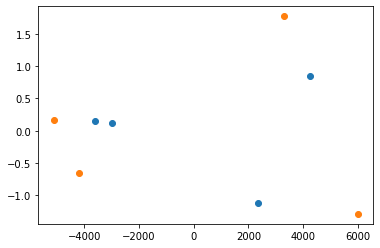

In [65]:
pca = PCA(n_components=2)
T_aug = pca.fit_transform(X_aug)

plt.scatter(T[:, 0], T[:, 1], label='Normal')
plt.scatter(T_aug[:, 0], T_aug[:, 1], label='Augmented')

In [ ]:
# Slighly different transformed values due to the randomly generated noise columns
# More explanations / plots